# Lab 5. Neural Networks. Optimizers comparison
### Kirill Zakharov

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline

import torch
import tqdm
import torch.nn as nn
torch.manual_seed(0)
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

plt.style.use('ggplot')

Возьмем все те же данные.

In [2]:
data_stock = pd.read_csv('zeus.us.txt')['Close'].values
data_energy = pd.read_csv('energy_data.csv').iloc[:,0].values

Переведем в интервал [0, 1] для устойчивости обчения нейронной сети.

In [3]:
scaler = MinMaxScaler()
data_stock = scaler.fit_transform(data_stock.reshape(-1, 1)).T[0]
data_energy = scaler.fit_transform(data_energy.reshape(-1, 1)).T[0]

Функция для создания окон, будем резать временной ряд на окна и предсказывать следующее значение после.

In [4]:
def window_split(time_series, k):
    x = []
    y = []
    
    for i in range(len(time_series) - k + 1):
        x.append([time_series[i+j] for j in range(k)])
        
    for i in range(len(time_series) - k):
        y.append(time_series[i+k])
        
    return x[:-1], y

In [5]:
x_stock, y_stock = window_split(data_stock, 10)
x_energy, y_energy = window_split(data_energy, 4)

In [6]:
X_st = torch.FloatTensor(np.array(x_stock).reshape(len(x_stock), 10, 1))
X_en = torch.FloatTensor(np.array(x_energy).reshape(len(x_energy), 4, 1))

In [7]:
Y_st = torch.FloatTensor(y_stock)
Y_en = torch.FloatTensor(y_energy)

In [51]:
# X_train, X_test = X_st[:-36], X_st[-36:]
# Y_train, Y_test = Y_st[:-36], Y_st[-36:]
X_train, X_test = X_en[:-20], X_en[-20:]
Y_train, Y_test = Y_en[:-20], Y_en[-20:]

Для предсказания будем использовать рекурентную сеть с полносвязным слоем в конце.

In [93]:
class LSTM(nn.Module):
    def __init__(self, hidden_size):
        super(LSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = 1
        
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=self.num_layers, batch_first=True)
        self.linear_layer = nn.Linear(in_features=hidden_size * self.num_layers, out_features=1)

    def forward(self, inputs):
        
        h_0 = torch.zeros(self.num_layers, inputs.size(0), self.hidden_size)
        c_0 = torch.zeros(self.num_layers, inputs.size(0), self.hidden_size)

        output_features, (h_out, _) = self.lstm(inputs, (h_0, c_0))
        h_out = h_out.view(inputs.size(0), self.num_layers * self.hidden_size)
        # out = self.linear_layer(h_out[inputs.size(0):])
        
        out = self.linear_layer(h_out)
        
        return out

Функции потерь.

In [122]:
class MAE(nn.Module):
    def __init__(self) -> None:
        super(MAE, self).__init__()
        
    def forward(self, x, y):
        return torch.mean(torch.abs(x - y))

Класс для проведения экспреиментов. Возьмем для сравнения 4 основных оптимизатора: Adam, RMSprop, Adagrad, SGD. Для функций потерь возьмем две: MSE, MAE.

In [146]:
class Model:
    def __init__(self, optim_type, loss_type) -> None:
        self.optim_type = optim_type
        self.loss_type = loss_type
        self.LSTM = LSTM(2**7)
        
    def fit(self, X_train, Y_train, epochs=200, lr=0.01):
        epochs = tqdm.tqdm(range(epochs))
        if self.optim_type == 'Adam':
            optimizer = torch.optim.Adam(self.LSTM.parameters(), lr=lr)
            
        elif self.optim_type == 'Adagrad':
            optimizer = torch.optim.Adagrad(self.LSTM.parameters(), lr=lr)
            
        elif self.optim_type == 'RMSprop':
            optimizer = torch.optim.RMSprop(self.LSTM.parameters(), lr=lr)
            
        elif self.optim_type == 'SGD':
            optimizer = torch.optim.SGD(self.LSTM.parameters(), lr=lr)
            
        else:
            print('Choose optimizer type')
            
            
        if self.loss_type == 'MSE':
            criterion = nn.MSELoss()
            
        elif self.loss_type == 'MAE':
            criterion = MAE()
        
        losses = []
        for _ in epochs:
            pred = self.LSTM(X_train)
            loss = criterion(pred, Y_train.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epochs.set_description(f'Loss: {loss.item()}')
            losses.append(loss.item())
            
        return losses

In [147]:
model = Model('Adam', 'MSE')
losses = model.fit(X_train, Y_train, epochs=1000, lr=0.01)

Loss: 6.196452886797488e-05: 100%|██████████| 1000/1000 [00:04<00:00, 208.35it/s]


In [149]:
prediction = model.LSTM(X_test).data.numpy()
prediction = scaler.inverse_transform(prediction)

Нарисуем предсказания для оптимизатора Adam и функции потерь MSE.

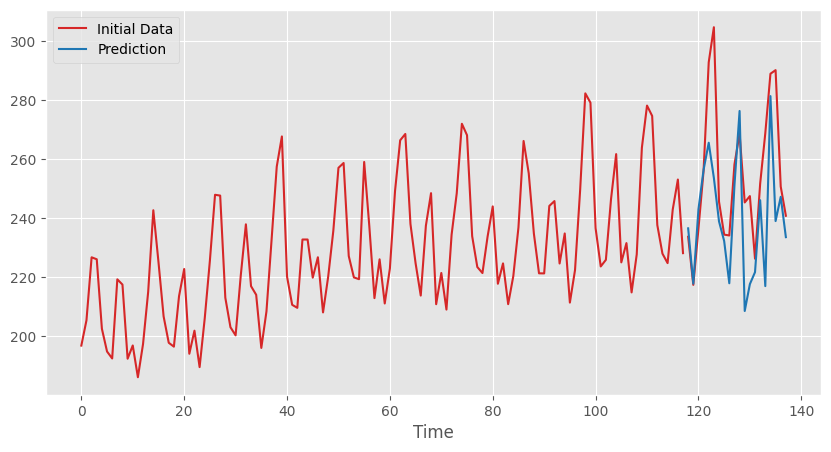

In [150]:
plt.subplots(figsize=(10, 5))


plt.plot(np.arange(len(Y_train)), scaler.inverse_transform(Y_train.data.numpy().reshape(-1, 1)), color='tab:red')
plt.plot(np.arange(len(Y_test))+len(X_train), scaler.inverse_transform(Y_test.data.numpy().reshape(-1, 1)), label='Initial Data', color='tab:red')
plt.plot(np.arange(len(Y_test))+len(X_train), prediction, label='Prediction', color='tab:blue')
plt.xlabel('Time')

# plt.title('Number of Passengers', fontsize=16)
plt.legend()
plt.show()

Теперь запустим обучение для всех оптимизаторов и функций потерь.

In [204]:
pred_array = []

losses_total = []
loss_names = ['MSE', 'MAE']
optimizers = ['Adam', 'Adagrad', 'RMSprop', 'SGD']

for loss in loss_names:
    losses_array = []
    
    for opt in optimizers:
        model = Model(opt, loss)
        losses = model.fit(X_train, Y_train, epochs=2000, lr=0.001)
        
        prediction = model.LSTM(X_test).data.numpy()
        prediction = scaler.inverse_transform(prediction)
        
        pred_array.append(prediction)
        losses_array.append(losses)
        
    losses_total.append(losses_array)

Loss: 0.14111918210983276: 100%|██████████| 2000/2000 [00:07<00:00, 280.59it/s]


In [205]:
metrics = []
for pred in pred_array:
   metrics.append([mean_squared_error(scaler.inverse_transform(Y_test.reshape(-1, 1)), pred),\
      mean_absolute_percentage_error(scaler.inverse_transform(Y_test.reshape(-1, 1)), pred)])

По результатам видно, что лучше всего показал себя оптимизатор Adam, поскольку он ялвяется самым продвинутым из данных 4, так как это комбинация Adagrad и RMSprop. Также видно что обучение лучше было при функции ошибки MSE, так как данная функция усиливает большие ошибки и уменьшает маленькие, таким образом обучение стабилизируется. В случае MAE все значения равнозначны.

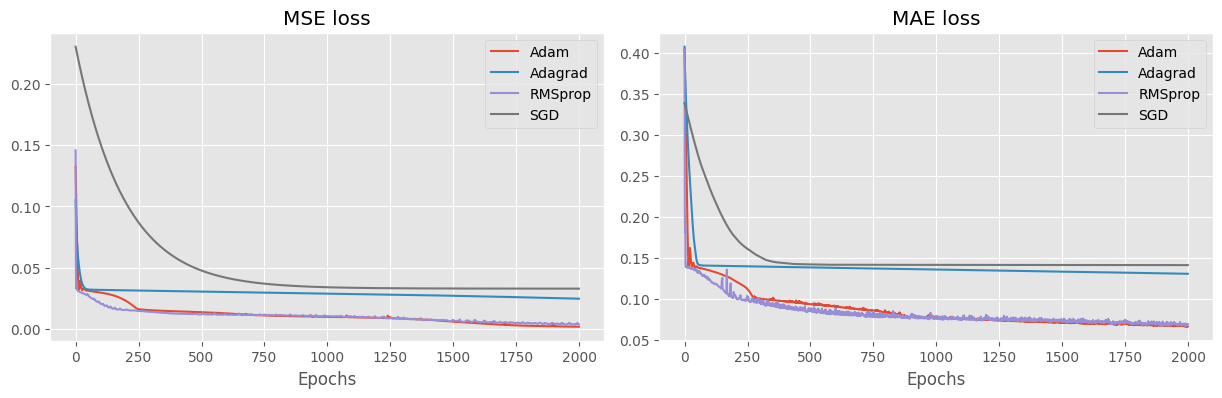

In [208]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4), dpi=100)


for j in range(len(loss_names)):
    for i in range(len(optimizers)):
        axs[j].plot(losses_total[j][i], label=optimizers[i])
        
        axs[j].legend()
        axs[j].set_title(f'{loss_names[j]} loss')
        axs[j].set_xlabel('Epochs')
    
plt.subplots_adjust(wspace=0.1)    
plt.show()